In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [6]:
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_recall_curve, 
    roc_curve, 
    roc_auc_score, 
    balanced_accuracy_score,
    brier_score_loss
)
from sklearn.calibration import calibration_curve


In [7]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

True

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [9]:
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    df['processed_text'] = df['email_text'].apply(preprocess_text)
    label_encoder = LabelEncoder()
    df['encoded_label'] = label_encoder.fit_transform(df['label'])
    return df, label_encoder

In [10]:
class EmailClassifier:
    def __init__(self, vectorizer=None):
        self.vectorizer = vectorizer or TfidfVectorizer(max_features=5000)
        self.models = {
            'Logistic Regression': LogisticRegression(multi_class='ovr', max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100),
            'SVM': SVC(probability=True)
        }
        
    def train_and_evaluate(self, X_train, X_test, y_train, y_test, label_encoder):
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)
        results = {}
        for name, model in self.models.items():
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_test_vec)
            y_pred_proba = model.predict_proba(X_test_vec)
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                'classification_report': classification_report(y_test, y_pred, target_names=label_encoder.classes_),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'y_pred_proba': y_pred_proba
            }
        return results
    
    def plot_roc_curves(self, X_test_vec, y_test, results, label_encoder):
        plt.figure(figsize=(15, 5))
        for name, model_results in results.items():
            y_pred_proba = model_results['y_pred_proba']
            for i, label in enumerate(label_encoder.classes_):
                y_test_binary = (y_test == i).astype(int)
                fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba[:, i])
                roc_auc = roc_auc_score(y_test_binary, y_pred_proba[:, i])
                plt.plot(fpr, tpr, label=f'{name} - {label} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (One-vs-Rest)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_precision_recall_curves(self, X_test_vec, y_test, results, label_encoder):
        plt.figure(figsize=(15, 5))
        for name, model_results in results.items():
            y_pred_proba = model_results['y_pred_proba']
            for i, label in enumerate(label_encoder.classes_):
                y_test_binary = (y_test == i).astype(int)
                precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba[:, i])
                plt.plot(recall, precision, label=f'{name} - {label}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.tight_layout()
        plt.show()

Class Distribution:
label
Ham            203
Promotional    160
Spam           137
Name: count, dtype: int64

Logistic Regression Model Results:
Accuracy: 1.0
Balanced Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      1.00      1.00        51
 Promotional       1.00      1.00      1.00        40
        Spam       1.00      1.00      1.00        34

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



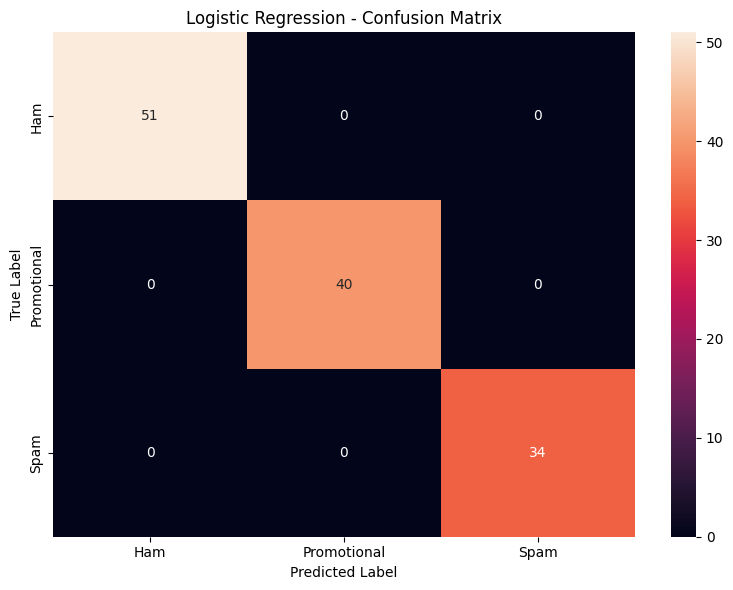


Random Forest Model Results:
Accuracy: 1.0
Balanced Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      1.00      1.00        51
 Promotional       1.00      1.00      1.00        40
        Spam       1.00      1.00      1.00        34

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



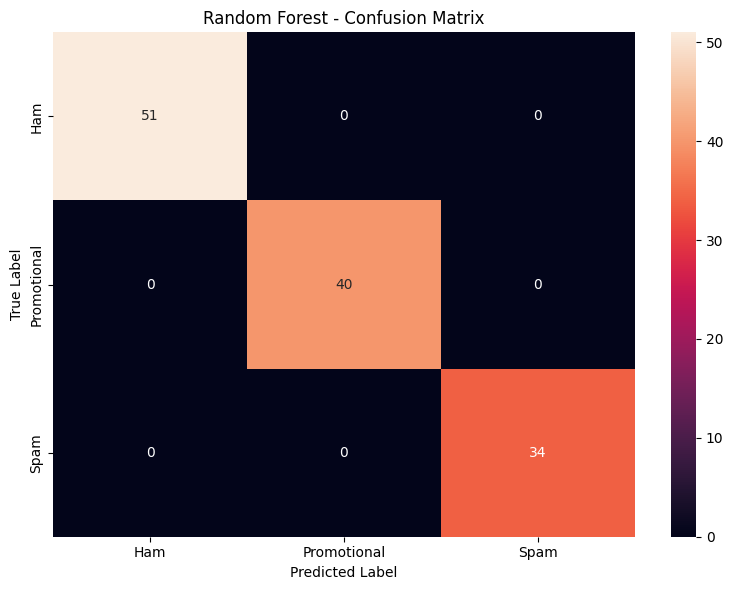


SVM Model Results:
Accuracy: 1.0
Balanced Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      1.00      1.00        51
 Promotional       1.00      1.00      1.00        40
        Spam       1.00      1.00      1.00        34

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



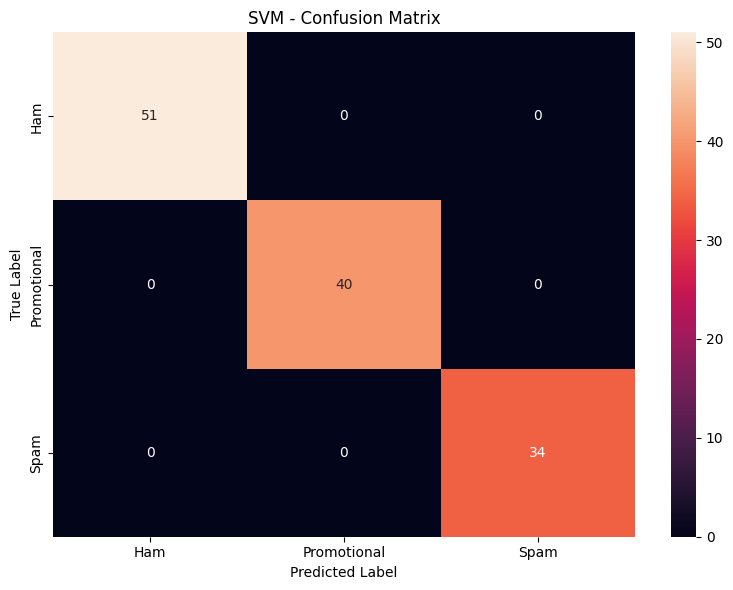

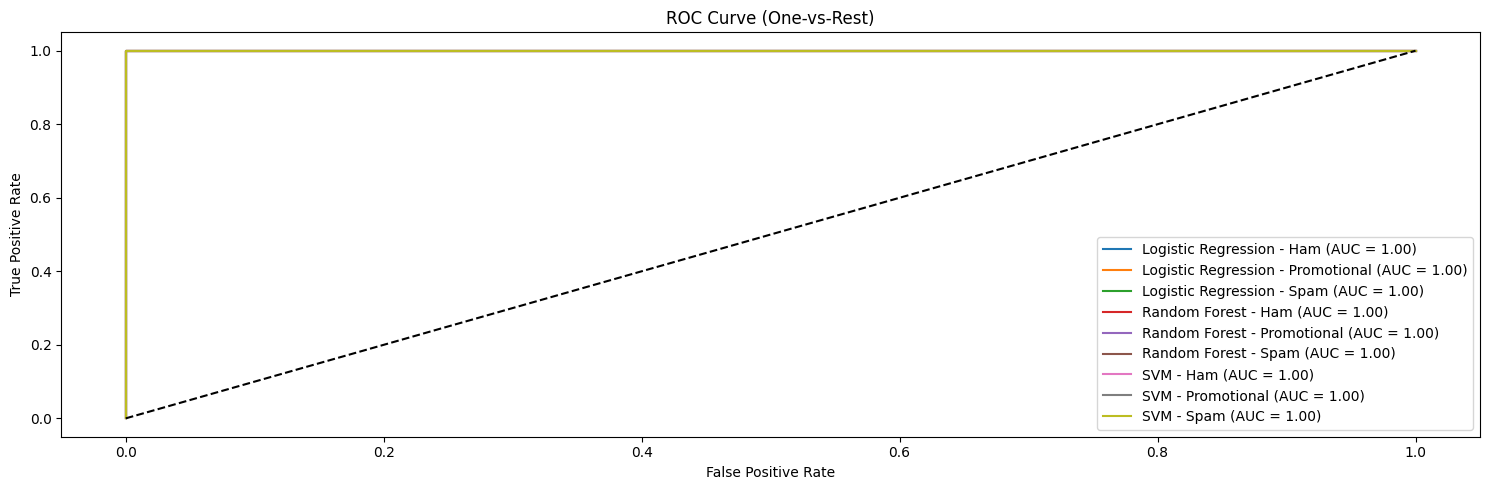

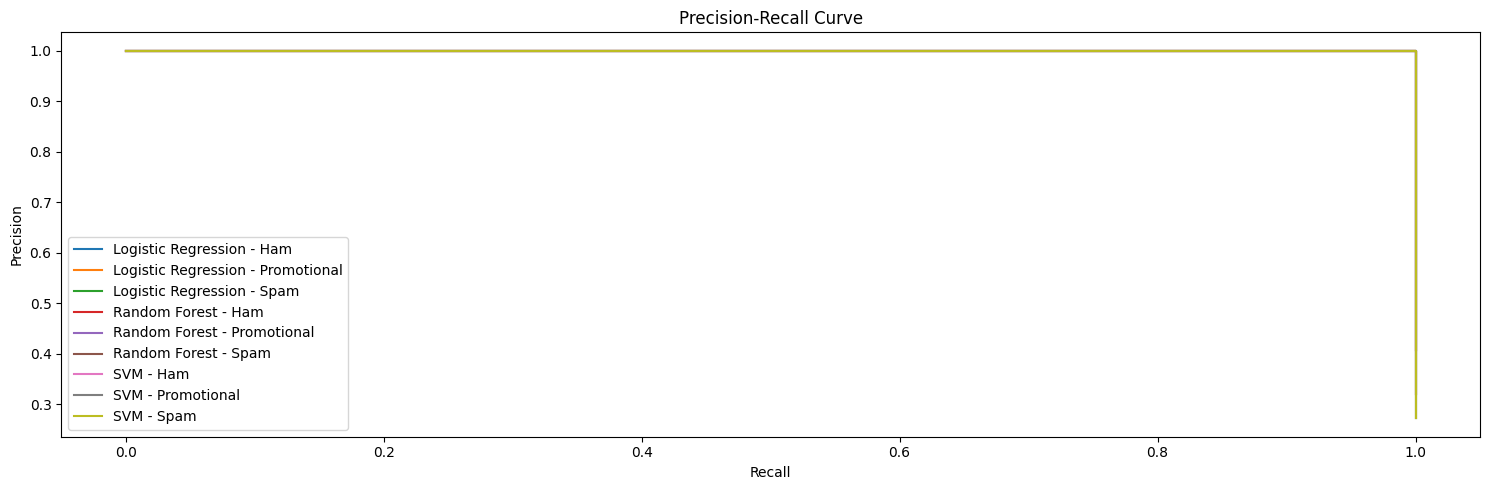

In [11]:
df, label_encoder = load_dataset('email_classification_1000.csv')
print("Class Distribution:")
print(df['label'].value_counts())
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    df['encoded_label'], 
    test_size=0.25, 
    random_state=42, 
    stratify=df['encoded_label']
)

# Initialize and train classifier
classifier = EmailClassifier()
results = classifier.train_and_evaluate(X_train, X_test, y_train, y_test, label_encoder)

# Print results
for name, metrics in results.items():
    print(f"\n{name} Model Results:")
    print("Accuracy:", metrics['accuracy'])
    print("Balanced Accuracy:", metrics['balanced_accuracy'])
    print("\nClassification Report:\n", metrics['classification_report'])
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], 
                annot=True, 
                fmt='d', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# ROC and Precision-Recall Curves
X_test_vec = classifier.vectorizer.transform(X_test)
classifier.plot_roc_curves(X_test_vec, y_test, results, label_encoder)
classifier.plot_precision_recall_curves(X_test_vec, y_test, results, label_encoder)


   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   2.026592   1.992471   1.608643   1.600153   1.381684   1.421800   
1   1.726777   2.157633   1.052574  -0.459732   1.289835   0.576191   
2   0.004809   0.429846   1.890836   0.941522   1.910098  -0.819555   
3   0.528796   1.139613  -0.031222   1.162008   2.379404   0.562134   
4  -3.135415  -1.758345   0.693092   1.045431   0.821968  -0.312730   

   Feature_6  Feature_7  Feature_8  Feature_9  
0   1.552129   1.386526   2.563770   0.767046  
1   2.067122  -0.038260   1.250180   0.751520  
2   0.285375   1.097180   1.873757  -0.533102  
3  -0.215513   1.472715  -0.065242   0.164072  
4  -1.713924   1.687074  -2.071417  -0.022467  


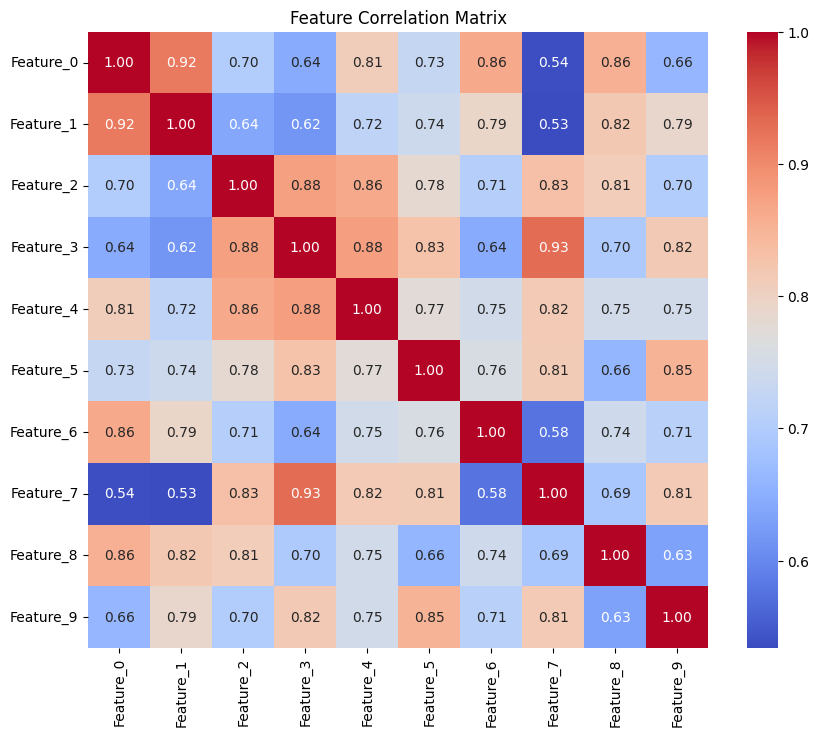

In [11]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of features
n_features = 10
n_samples = 50

# Generate a random correlation matrix
A = np.random.rand(n_features, n_features)
cov_matrix = np.dot(A, A.T)  # Ensure it's positive semi-definite



# Generate random means for each feature
means = np.random.rand(n_features)

# Generate synthetic data
synthetic_data = np.random.multivariate_normal(means, cov_matrix, size=n_samples)

# Convert to pandas DataFrame
df = pd.DataFrame(synthetic_data, columns=[f"Feature_{i}" for i in range(n_features)])

print(df.head())  # Display first few rows


import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr()

# Visualize with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()




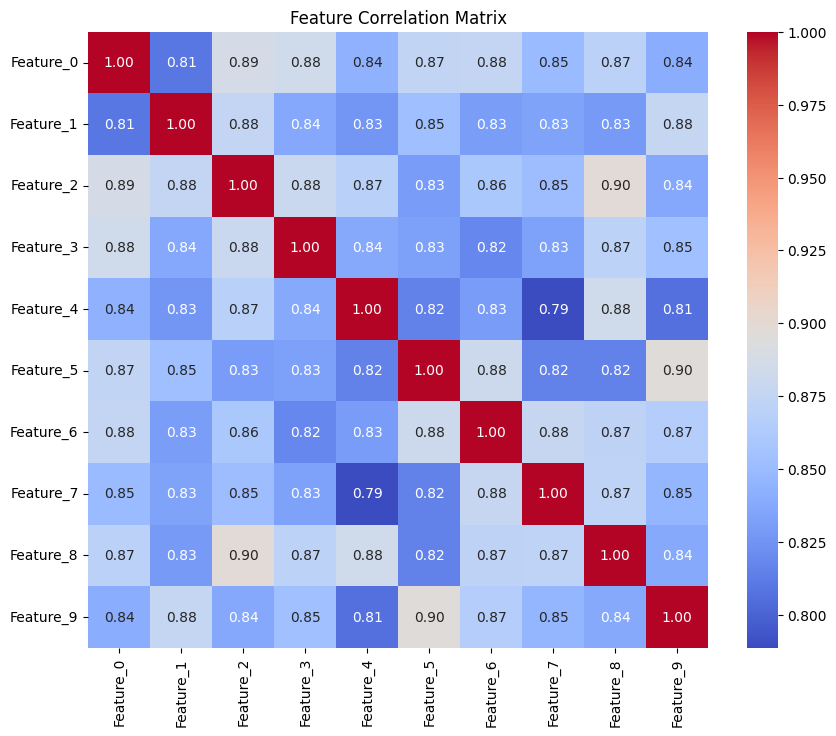

In [9]:
import numpy as np

# Number of features and samples
n_features = 10
n_samples = 50

# Step 1: Create a correlation matrix (example: 0.8 correlation off-diagonal)
corr = 0.8
corr_matrix = np.full((n_features, n_features), corr)
np.fill_diagonal(corr_matrix, 1.0)

# Step 2: Convert correlation matrix to covariance matrix (std dev = 1)
cov_matrix = corr_matrix

# Step 3: Generate synthetic data
mean = np.zeros(n_features)
synthetic_data = np.random.multivariate_normal(mean, cov_matrix, size=n_samples)

# synthetic_data is a (50, 10) array with correlated features
df = pd.DataFrame(synthetic_data, columns=[f"Feature_{i}" for i in range(n_features)])

corr_matrix = df.corr()

# Visualize with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()